In [1]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [38]:
# data_path = "data_cleaned_feature_31.parquet"
# data = pd.read_parquet(data_path)
# print(data.columns)
# data.shape

In [39]:
data_path = "data_youtube_cleaned_final_2.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

(23933, 43)

In [15]:
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
0    12703
1    11230
Name: count, dtype: int64

In [16]:
data['is_weekend'].value_counts()

is_weekend
False    16921
True      7012
Name: count, dtype: int64

In [17]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from ultralytics import YOLO  # Use ultralytics YOLO package or adapt for YOLOv5
import os
from icecream import ic 
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch
from torchvision import models, transforms
import logging

model = YOLO('yolo11n.pt')
model.overrides['verbose'] = False  # Disable verbose logging
# logging.getLogger("ultralytics").setLevel(logging.ERROR)
thumbnail_urls = data['video_default_thumbnail']
def detect_objects(image):
    results = model(image)  # Perform detection
    detections_df = results[0].to_df()  # Convert detections to a DataFrame
    
    # Check if detections_df is empty
    if detections_df.empty:
        return {'contain_1': None, 'contain_2': None, 'contain_3': None}  # No objects detected

    # Count object occurrences using the 'name' column
    object_counts = detections_df['name'].value_counts()

    # Extract the top 3 detected objects (if available)
    top_objects = object_counts.index.tolist()[:3]
    contains_face = int('person' in top_objects)

    # Map to new keys for clarity
    result = {
        'contain_1': top_objects[0] if len(top_objects) > 0 else None,
        'contain_2': top_objects[1] if len(top_objects) > 1 else None,
        'contain_3': top_objects[2] if len(top_objects) > 2 else None,
    }
    
    return result

def analyze_colors(image):
    image = image.resize((100, 100))  # Resize for speed
    pixels = np.array(image).reshape(-1, 3)  # Flatten pixels
    dominant_color = np.mean(pixels, axis=0)  # Average color (RGB)
    brightness = np.mean(np.sqrt(np.sum(pixels**2, axis=1)))  # Brightness metric
    color_diversity = len(np.unique(pixels, axis=0))  # Distinct colors
    return {
        'dominant_color_r': dominant_color[0],
        'dominant_color_g': dominant_color[1],
        'dominant_color_b': dominant_color[2],
        'brightness': brightness,
        'color_diversity': color_diversity
    }

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 34.9MB/s]


In [ ]:
results_list = []
for url in tqdm(thumbnail_urls, desc="Processing Thumbnails", unit="image"):
    try:
        # Download image
        response = requests.get(url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Detect objects
        detection_results = detect_objects(image)
        color_analysis = analyze_colors(image)
        combined_results = {**detection_results, **color_analysis, 'thumbnail_url': url}
        results_list.append(combined_results)
    
    except Exception as e:
        print(f"Failed to process {url}: {e}")
        results_list.append({'thumbnail_url': url, 'error': str(e)})

final_data = pd.merge(data, pd.DataFrame(results_list), how="left", left_on='video_default_thumbnail', right_on='thumbnail_url')

Processing Thumbnails:  48%|████▊     | 11448/23933 [41:03<38:23,  5.42image/s]  

In [21]:
# final_data.to_csv("yolo_image_data.csv", index=False)

In [2]:
final_data = pd.read_csv("yolo_image_data_12082024.csv")
final_data.shape

(28667, 52)

In [3]:
final_data.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

In [4]:
final_data.time_to_trend_difference_seconds

0         86394.0
1        374390.0
2        261583.0
3        390372.0
4        316800.0
           ...   
28662     53993.0
28663    138586.0
28664     25145.0
28665    115152.0
28666    113395.0
Name: time_to_trend_difference_seconds, Length: 28667, dtype: float64

In [5]:
data = final_data.copy()
data.shape

(28667, 52)

In [6]:
text_features = ['video_title']

def clean_text_column(column):
    """Clean a text column by filling nulls and removing special characters."""
    return (
        column.fillna("")  # Fill missing values with empty string
        .str.replace(r"[^\w\s]", " ", regex=True)  # Remove special characters
        .str.lower()  # Convert to lowercase
        .str.strip()  # Remove leading/trailing spaces
    )

for text_feature in text_features:
    data[text_feature] = clean_text_column(data[text_feature])

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('Snowflake/snowflake-arctic-embed-m-v2.0', trust_remote_code=True)
sentence_embeddings = {}
for text_feature in text_features:
    text_data = data[text_feature].tolist()
    embeddings = model.encode(text_data, show_progress_bar=True)
    sentence_embeddings[text_feature] = pd.DataFrame(
        embeddings, 
        columns=[f"{text_feature}_dim{i}" for i in range(embeddings.shape[1])]
    )

embedded_text = pd.concat(sentence_embeddings.values(), axis=1)

Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


Batches:   0%|          | 0/896 [00:00<?, ?it/s]

In [7]:
embedded_text

,video_title_dim0,video_title_dim1,video_title_dim2,video_title_dim3,video_title_dim4,video_title_dim5,video_title_dim6,video_title_dim7,video_title_dim8,video_title_dim9,...,video_title_dim758,video_title_dim759,video_title_dim760,video_title_dim761,video_title_dim762,video_title_dim763,video_title_dim764,video_title_dim765,video_title_dim766,video_title_dim767
0,0.009093,0.021144,-0.008860,-0.064535,0.003731,-0.035317,-0.036237,-0.075430,0.068747,-0.031702,...,0.031078,0.012558,0.005517,-0.002610,-0.029585,-0.029494,-0.006481,0.020358,0.003455,-0.036908
1,-0.004329,-0.068817,-0.005405,0.057014,-0.050793,0.013811,-0.039786,0.034869,-0.030075,0.050910,...,0.080197,0.028814,-0.002630,-0.009517,-0.030325,0.027094,-0.008299,-0.013473,-0.057107,0.010991
2,-0.076475,-0.005609,-0.088073,-0.038762,-0.049585,-0.058046,-0.047675,-0.002589,0.046021,-0.004440,...,-0.017091,-0.013402,-0.008842,-0.005788,-0.055960,0.023729,-0.020386,-0.015047,-0.013474,-0.002428
3,-0.052240,0.054189,-0.062050,-0.043521,0.024455,-0.072412,-0.066103,-0.021296,0.039994,0.018421,...,0.053687,-0.010949,0.024411,-0.013131,-0.036337,-0.025544,-0.067384,-0.020587,-0.030198,0.024231
4,0.049462,0.024351,-0.034504,-0.004160,0.043551,0.002668,-0.054742,0.023563,-0.015602,-0.008923,...,-0.003383,-0.047029,0.026381,-0.013540,-0.004209,0.002244,-0.052437,-0.001880,-0.095914,-0.000255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28662,0.021674,-0.047585,-0.083370,-0.046521,-0.060033,-0.042181,0.011170,-0.041465,0.077218,-0.022856,...,0.029917,-0.006506,-0.015061,-0.025143,-0.016077,0.001346,0.013126,-0.034247,-0.014442,0.001682
28663,-0.023548,-0.000685,-0.046862,0.000552,-0.040419,-0.023264,-0.003123,-0.055641,-0.042562,0.023054,...,0.001573,0.007381,0.028332,-0.038406,-0.072155,-0.040280,-0.015877,-0.049243,-0.000857,0.017989
28664,0.000053,-0.047104,-0.024426,0.002769,-0.021392,-0.009642,0.057881,-0.002587,-0.001672,0.014512,...,0.033934,0.011135,-0.037110,-0.015543,-0.039739,0.013641,-0.044061,-0.028385,0.002148,0.002315
28665,-0.032445,-0.000637,-0.000955,-0.066391,0.022123,-0.038293,-0.004615,-0.012204,-0.020850,-0.017536,...,0.078068,0.001750,-0.037340,-0.084835,-0.006891,-0.010650,0.039374,-0.045501,-0.050603,-0.026910


In [8]:
data['tag_count'] = data['video_tags'].apply(lambda x: 0 if x == 'No tags' else len(x.split(',')))
data['tag_count'].value_counts()

tag_count
0      7748
6       669
4       663
23      657
14      652
       ... 
105       1
94        1
93        1
131       1
111       1
Name: count, Length: 110, dtype: int64

In [9]:
from sklearn.decomposition import PCA
embedding_dim = 16
pca = PCA(n_components=embedding_dim)
reduced_embeddings = pca.fit_transform(np.array(embedded_text))

embedding_columns = [f"text_embeddings_{i}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(reduced_embeddings, columns=embedding_columns)
embedding_df.shape

(28667, 16)

In [10]:
data = pd.concat([data, embedding_df], axis=1)
data.shape

(28667, 69)

In [11]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2',
       'contain_3'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_g', 'dominant_color_b',
       'brightness', 'color_diversity','tag_count'
]

In [12]:
final_data.channel_video_count

0           43
1         5274
2        36548
3          920
4          952
         ...  
28662      318
28663     3383
28664       72
28665       21
28666       28
Name: channel_video_count, Length: 28667, dtype: int64

In [13]:
embedded_text_columns = embedding_df.columns.tolist()
embedded_text_columns
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
X_text = data[embedded_text_columns]
y = data['is_trending']

In [14]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [15]:
import numpy as np
X = pd.concat((X_numerical, X_categorical, X_text),axis=1)
X.shape

(28667, 39)

In [71]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
pipeline = Pipeline([
    ("categorical_imputer", CategoricalImputer(
    variables=['contain_1', 'contain_2', 'contain_3'],
    fill_value="Empty")),
    ("rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=False)),
    ("num_rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=True, variables=['tag_count'], replace_with=-1)),
    ("drop_constant_features", DropConstantFeatures(tol=0.90)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.90))
])

X_final = pipeline.fit_transform(X)
X_final.shape

/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_definition is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_dimension is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


(28667, 35)

In [72]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers',
 'video_definition',
 'video_dimension',
 'video_licensed_content'}

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=0)

In [75]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'channel_country', 
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2','contain_3'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_b', 'dominant_color_g',
       'brightness', 'color_diversity','tag_count'
]

In [76]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

X_train_text = X_train[embedded_text_columns]
X_test_text = X_test[embedded_text_columns]

In [77]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(random_state=42, regression=False)
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

In [78]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [79]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

In [80]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_numerical)
# X_test_scaled = scaler.transform(X_test_numerical)
# # X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)
# X_train = np.hstack((X_train_encode, X_train_scaled))
# X_test = np.hstack((X_test_encode, X_test_scaled))

Model Accuracy: 0.7054412277642135
[[2105  827]
 [ 862 1940]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      2932
           1       0.70      0.69      0.70      2802

    accuracy                           0.71      5734
   macro avg       0.71      0.71      0.71      5734
weighted avg       0.71      0.71      0.71      5734



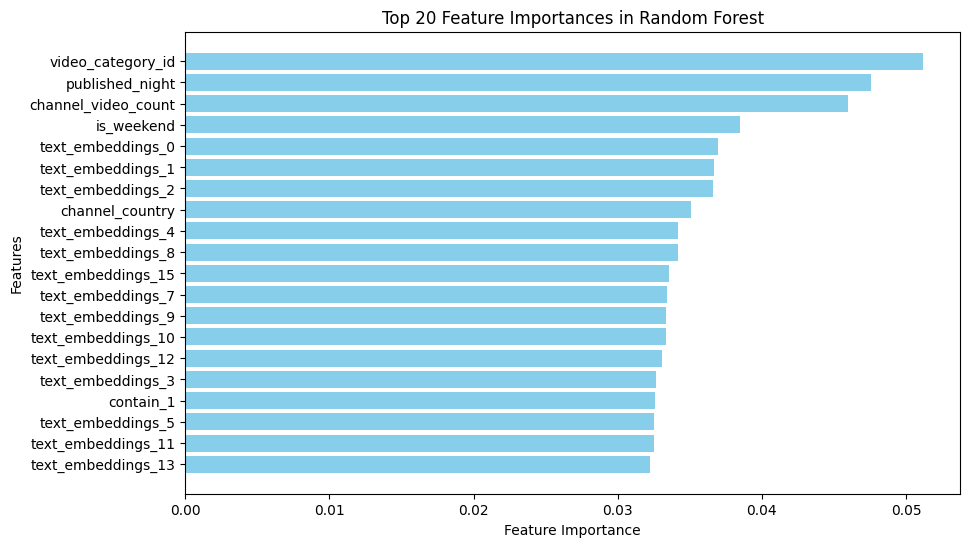

,Feature Prefix,Total Importance
0,text_embeddings,0.539265


In [81]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mmx_scaler = StandardScaler()
X_train_mmx = mmx_scaler.fit_transform(np.hstack((X_train_numerical, X_train_encode, X_train_text)))
X_test_mmx = mmx_scaler.transform(np.hstack((X_test_numerical, X_test_encode, X_test_text)))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_names = pd.concat([data[categorical_features],data[numerical_features],data[embedded_text_columns]]).columns
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in Random Forest')
plt.gca().invert_yaxis()  
plt.show()

importance_df['Prefix'] = importance_df['Feature'].str.extract(r'(text_embeddings)')

# Group by the extracted prefix and sum the importance values
aggregated_importance = importance_df.groupby('Prefix')['Importance'].sum().reset_index()

# Rename columns for clarity
aggregated_importance.columns = ['Feature Prefix', 'Total Importance']
aggregated_importance

Model Accuracy: 0.7075340076735264
[[2111  821]
 [ 856 1946]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2932
           1       0.70      0.69      0.70      2802

    accuracy                           0.71      5734
   macro avg       0.71      0.71      0.71      5734
weighted avg       0.71      0.71      0.71      5734



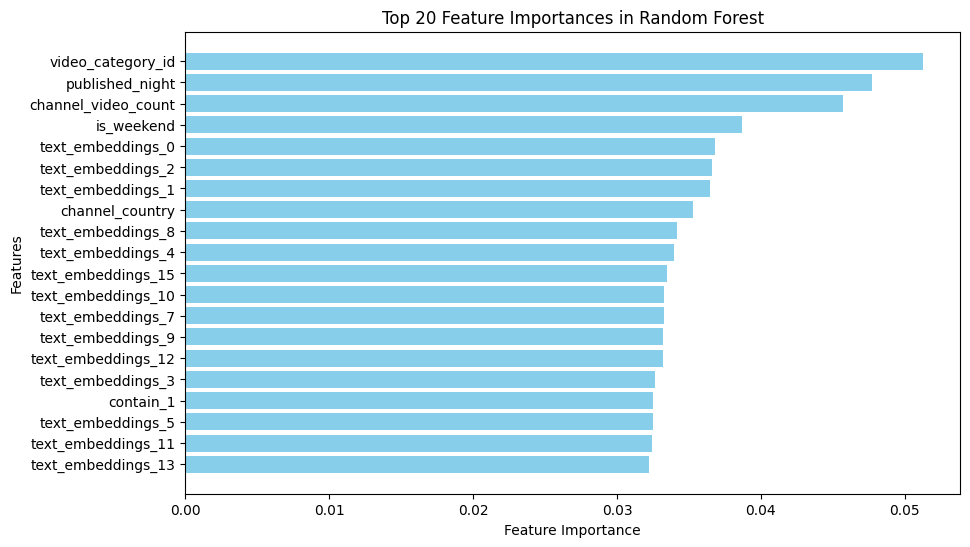

,Feature Prefix,Total Importance
0,text_embeddings,0.538154


In [82]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = MinMaxScaler()
X_train_mmx = np.hstack((X_train_numerical, X_train_encode,X_train_text))
X_test_mmx = np.hstack((X_test_numerical, X_test_encode, X_test_text))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_names = pd.concat([data[categorical_features],data[numerical_features],data[embedded_text_columns]]).columns
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in Random Forest')
plt.gca().invert_yaxis()  
plt.show()

importance_df['Prefix'] = importance_df['Feature'].str.extract(r'(text_embeddings)')

# Group by the extracted prefix and sum the importance values
aggregated_importance = importance_df.groupby('Prefix')['Importance'].sum().reset_index()

# Rename columns for clarity
aggregated_importance.columns = ['Feature Prefix', 'Total Importance']
aggregated_importance

Model Accuracy: 0.7075340076735264
[[2111  821]
 [ 856 1946]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2932
           1       0.70      0.69      0.70      2802

    accuracy                           0.71      5734
   macro avg       0.71      0.71      0.71      5734
weighted avg       0.71      0.71      0.71      5734



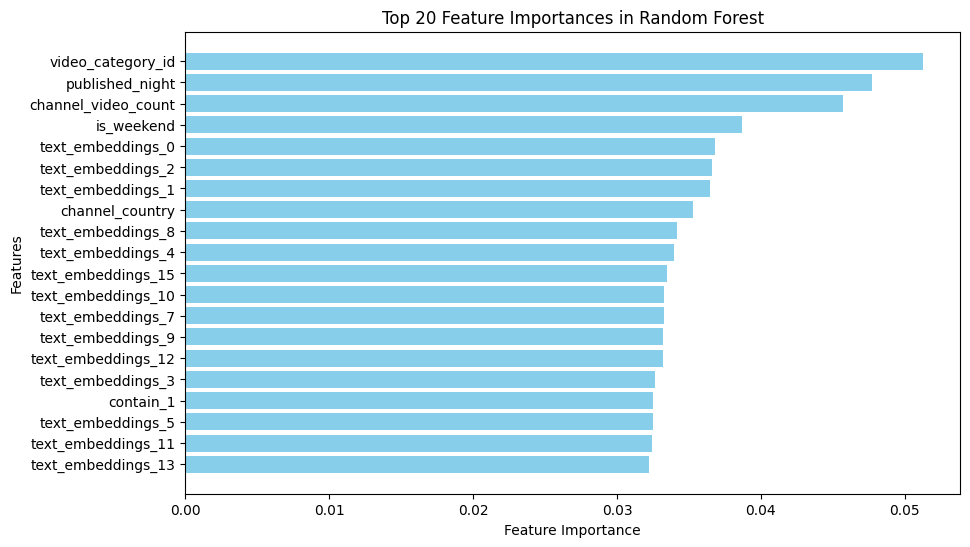

,Feature Prefix,Total Importance
0,text_embeddings,0.538154


In [83]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = StandardScaler()
X_train_mmx = np.hstack((X_train_numerical, X_train_encode, X_train_text))
X_test_mmx = np.hstack((X_test_numerical, X_test_encode, X_test_text))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_names = pd.concat([data[categorical_features],data[numerical_features],data[embedded_text_columns]]).columns
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in Random Forest')
plt.gca().invert_yaxis()  
plt.show()

importance_df['Prefix'] = importance_df['Feature'].str.extract(r'(text_embeddings)')

# Group by the extracted prefix and sum the importance values
aggregated_importance = importance_df.groupby('Prefix')['Importance'].sum().reset_index()

# Rename columns for clarity
aggregated_importance.columns = ['Feature Prefix', 'Total Importance']
aggregated_importance